In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import sklearn.feature_selection

In [156]:
df = pd.read_csv('customer_churn_master.csv')

# Checking Data

In [20]:
def missing_values(data):
  df = pd.read_csv('customer_churn_master.csv')
  for col in list(data):
    unique_values = data[col].unique()
    try:
      unique_values = np.sort(unique_values)
    except:
      pass
    nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
    zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
    #empty = round((data[data[col]] == '').sum()/data.shape[0]*100,1)
    df = df.append(pd.DataFrame([col, len(unique_values), nans,  zeros]).T, ignore_index = True)
  return df.rename(columns = {0: 'variable',
                              1: 'Unique values',
                              2: 'Nan %',
                              3: 'zeros %',
                              4: 'empty'}).sort_values('Nan %', ascending=False)
missing_values(df)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,age_group,variable,Unique values,Nan %,zeros %
7081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,clientnum,7081,0.0,0.0
7082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,attrition_flag,2,0.0,0.0
7101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,total_trans_ct,124,0.0,0.0
7100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,total_ct_chng_q4_q1,771,0.0,0.1
7099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,total_trans_amt,4194,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076,714082308.0,Attrited Customer,3.0,Blue,13.0,1.0,3.0,8656.0,8656.0,0.000,39.0,M,High School,Single,$80K - $120K,2.0,0.0,0.893,8056.0,0.935,89.0,30 - 39,NaN,NaN,NaN,NaN
7077,710751033.0,Attrited Customer,1.0,Blue,13.0,1.0,3.0,4829.0,4829.0,0.000,31.0,F,Graduate,Single,Less than $40K,1.0,0.0,0.836,8286.0,0.857,65.0,30 - 39,NaN,NaN,NaN,NaN
7078,780118158.0,Existing Customer,0.0,Blue,13.0,2.0,4.0,3585.0,1165.0,0.675,27.0,M,Graduate,Single,Less than $40K,2.0,2420.0,0.812,15656.0,0.746,124.0,younger than 30,NaN,NaN,NaN,NaN
7079,779082633.0,Existing Customer,2.0,Blue,13.0,2.0,3.0,4107.0,3128.0,0.238,30.0,M,Uneducated,Single,$60K - $80K,3.0,979.0,0.647,14596.0,0.733,104.0,30 - 39,NaN,NaN,NaN,NaN


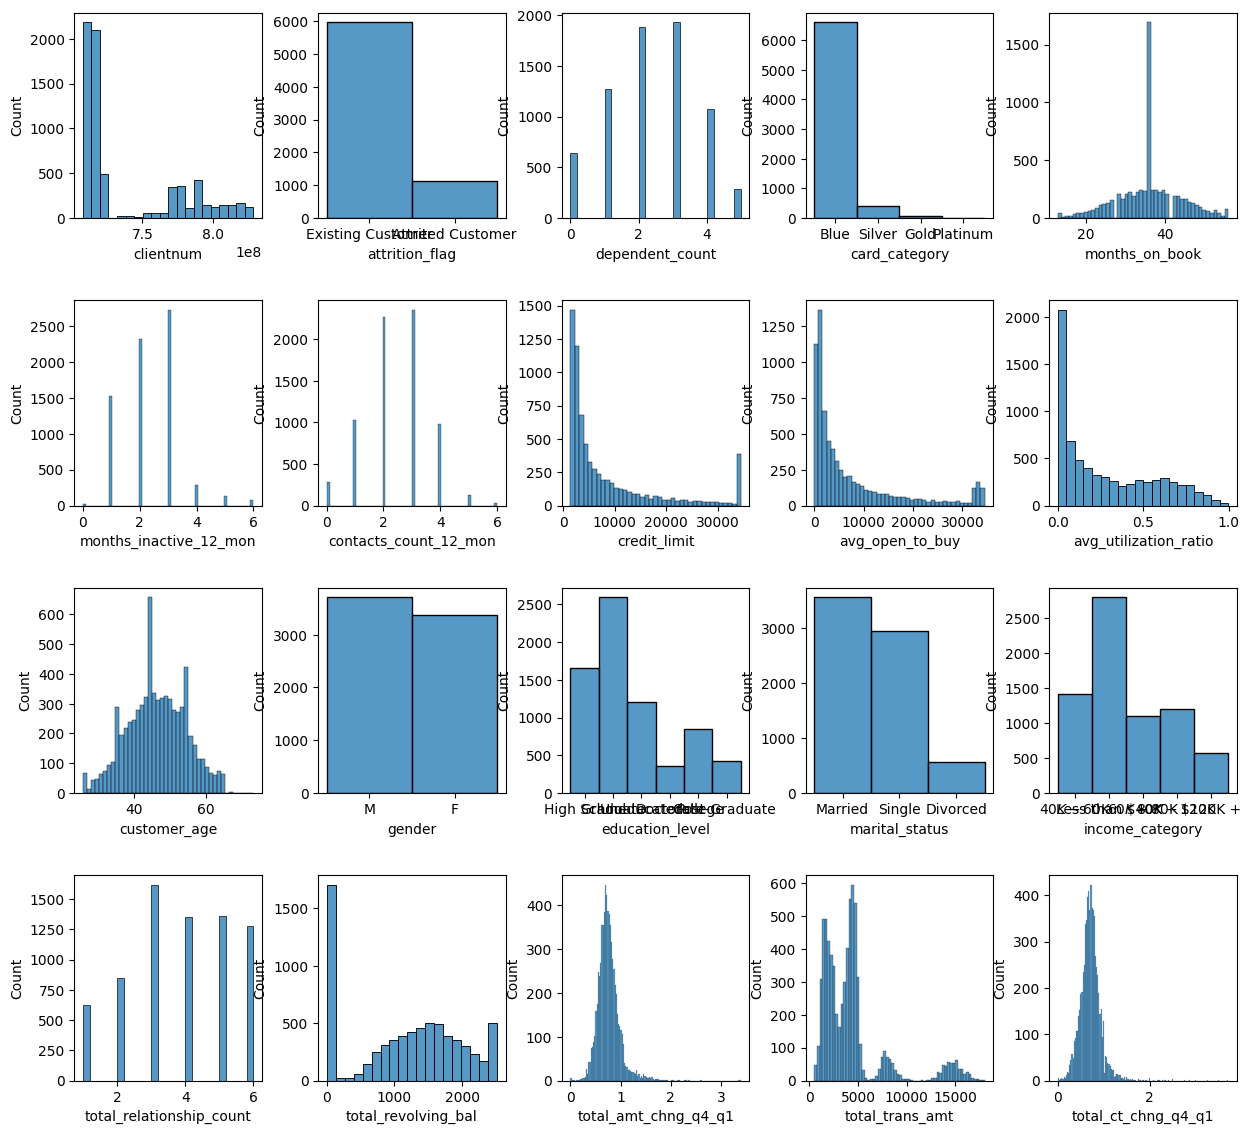

In [22]:
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.3, hspace=0.4)
for variable, subplot in zip(df.columns, ax.flatten()):
  sns.histplot(df[variable], ax=subplot)

# Weight of Evidence Encoding

In [2]:
pip install feature-engine

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.0/290.0 kB 39.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from feature_engine.encoding import WoEEncoder, RareLabelEncoder

In [23]:
df = pd.read_csv('churn_master.csv')

In [24]:
df.shape

(7081, 22)

In [10]:
df.head()

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,age_group
0,806160108,Existing Customer,1,Blue,56,2,3,3193.0,676.0,0.788,61,M,High School,Married,$40K - $60K,2,2517,1.831,1336,1.143,30,60 and up
1,717296808,Existing Customer,1,Blue,56,3,2,3006.0,489.0,0.837,67,F,Graduate,Married,Less than $40K,4,2517,2.053,1661,1.000,32,60 and up
2,809164083,Existing Customer,1,Blue,56,1,2,2619.0,840.0,0.679,63,M,Graduate,Married,$40K - $60K,2,1779,1.259,1450,0.947,37,60 and up
3,787348608,Existing Customer,0,Blue,56,2,3,3252.0,1757.0,0.460,70,M,High School,Married,Less than $40K,3,1495,0.581,1227,0.875,15,60 and up
4,778286433,Existing Customer,0,Blue,56,2,1,5876.0,4579.0,0.221,67,M,Graduate,Married,$40K - $60K,4,1297,1.012,2133,0.719,55,60 and up


In [7]:
# Separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                df.drop(['attrition_flag'], axis=1),
                df['attrition_flag'], test_size=0.3, random_state=0)

In [8]:
# set up a weight of evidence encoder
woe_encoder = WoEEncoder(variables=['card_category',
       'gender', 'education_level', 'marital_status',
       'income_category', 'age_group'])

# fit the encoder
woe_encoder.fit(X_train, y_train)

WoEEncoder(variables=['card_category', 'gender', 'education_level',
                      'marital_status', 'income_category', 'age_group'])

In [9]:
woe_encoder.encoder_dict_

{'card_category': {'Blue': -0.013407565396800054,
  'Gold': 1.4253707299911886,
  'Platinum': -1.7101234859379608,
  'Silver': -0.0752064882028757},
 'gender': {'F': -0.045422894828811115, 'M': 0.027295388590012924},
 'education_level': {'College': 0.05631817530580423,
  'Doctorate': -0.2806569529528616,
  'Graduate': 0.08255636991742261,
  'High School': -0.10662912740470859,
  'Post-Graduate': -0.09482045405146261,
  'Uneducated': 0.01929285271595847},
 'marital_status': {'Divorced': -0.24832157230992513,
  'Married': -0.05388150730605792,
  'Single': 0.10682623211865236},
 'income_category': {'$120K +': -0.05676633956902524,
  '$40K - $60K': 0.028036292067139455,
  '$60K - $80K': 0.12975523163429253,
  '$80K - $120K': -0.025675752498994068,
  'Less than $40K': -0.054700460262037245},
 'age_group': {'30 - 39': 0.5671437990717949,
  '40 - 49': -0.06242286776857225,
  '50 - 59': 0.008208514735276666,
  '60 and up': -0.1761931260120057,
  'younger than 30': 0.0816359832900941}}

## Statistical Analysis & Filtering

In [119]:
churn_rate = clean_df['attrition_flag'].value_counts()/clean_df['attrition_flag'].count()*100
churn_rate

Existing Customer    84.281881
Attrited Customer    15.718119
Name: attrition_flag, dtype: float64

In [124]:
exist_df = clean_df[clean_df.attrition_flag == "Existing Customer"]
attr_df = clean_df[clean_df.attrition_flag == "Attrited Customer"]

In [79]:
#let's create a copy version of dataframes

exist_df_copy = exist_df.copy()
clean_df_copy = clean_df.copy()
attr_df_copy = attr_df.copy()

In [80]:
#let's look at how many customers that fit into our attrited customer description 

# defining our filters based on our educated assumptions
attr_df_copy['filter_1'] = attr_df_copy['gender'].isin(['F'])
attr_df_copy['filter_2'] = attr_df_copy['education_level'].isin(['Collage', 'Doctorate'])
attr_df_copy['filter_3'] = attr_df_copy['marital_status'].isin(['Single', 'Divorced'])
attr_df_copy['filter_4'] = attr_df_copy['income_category'].isin(['Less than $40K', '$80K - $120K', '$120K +' ])
attr_df_copy['filter_5'] = attr_df_copy['total_relationship_count'] < 4
attr_df_copy['filter_6'] = attr_df_copy['age_group'].isin(['40 - 49', '50 - 59'])

# If all are true
attr_df_copy['filter_final'] = attr_df_copy[['filter_1', 'filter_2', 'filter_3', 'filter_4', 'filter_5', 'filter_6']].all(axis=1)

attr_df_copy_filtered = attr_df_copy[attr_df_copy['filter_final']]

In [82]:
number_of_customers = attr_df_copy_filtered['filter_final'].shape[0]

In [83]:
round(number_of_customers / len(attr_df_copy), 3)

0.01

Apperantly, based on our assumptions on the attrited customers were just 1% of the total attrited customers. So, instead of narrowing down the number of attrited customers with 6 different attributes, let's try to apply less filtering to increase our coverage in the dataset of attritted customers.

In [110]:
# If income category, total relationships count and age group are true
attr_df_copy['filter_final'] = attr_df_copy[['filter_4', 'filter_5', 'filter_6']].all(axis=1)

attr_df_copy_filtered = attr_df_copy[attr_df_copy['filter_final']]


In [129]:
attr_df_copy_filtered.shape

(354, 29)

In [111]:
number_of_customers = attr_df_copy_filtered['filter_final'].shape[0]

In [113]:
number_of_customers

354

In [86]:
round(number_of_customers / len(attr_df_copy), 3)

0.318

The result shows that by decreasing our assumptions, we increased our coverage to ~32%. If we say ~32% is good enough, then income category, total relationship count and age category attributions are the most associated attributes to the attritition. 


In [87]:
# Let's check the gender attribution separately

female_df = clean_df[clean_df.gender == "F"]
male_df = clean_df[clean_df.gender == "M"]

In [271]:
female_df.sample(3)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,age_group
494,812653383,Existing Customer,1,Blue,50,3,3,1843.0,323.0,0.825,55,F,College,Single,$40K - $60K,3,1520,0.864,4729,0.704,92,50 - 59
6034,712582983,Attrited Customer,3,Silver,36,3,1,14057.0,12676.0,0.098,47,F,Graduate,Married,Less than $40K,4,1381,1.039,4729,0.742,54,40 - 49
6473,718994583,Existing Customer,2,Blue,35,3,1,1438.3,622.3,0.567,48,F,College,Single,Less than $40K,3,816,0.842,4777,0.917,69,40 - 49


It seems that female customer tend to have more relationship counts in their transactions.This might be an opportunity to check the customers who are female and have more than 2 relationships behavior in terms of attrition.

In [90]:
female_df_copy = female_df.copy()

In [91]:
# With this insight in mind, let's check a new customer segment

female_df_copy['filter_7'] = female_df_copy['attrition_flag'].isin(['Attrited Customer'])
female_df_copy['filter_8'] = female_df_copy['total_relationship_count'] > 2


In [92]:
# If female, total relationships count assumptions are true

female_df_copy['filter_final'] = female_df_copy[['filter_7', 'filter_8']].all(axis=1)

female_df_copy_filtered = female_df_copy[female_df_copy['filter_final']]

In [93]:
number_of_female_segment = female_df_copy_filtered['filter_final'].shape[0]

In [94]:
round(number_of_female_segment / len(female_df_copy), 3)

0.12

Okay, when we apply two differeny attributes (attrited customers and having more than 2 total relationship counts), it reflected just 12% of the all female customers. Let's check only attrited customers percentage in the female customers.

In [116]:
# If we check the attrited customers in the female customer segment and in all customers

female_df_copy['filter_7'] = female_df_copy['attrition_flag'].isin(['Attrited Customer'])
female_df_copy['filter_8'] = female_df_copy['total_relationship_count'] > 4

female_df_copy['filter_final'] = female_df_copy[['filter_7']].all(axis=1)

female_df_copy_filtered = female_df_copy[female_df_copy['filter_final']]

In [117]:
number_of_female_attrited_segment = female_df_copy_filtered['filter_final'].shape[0]
number_of_female_attrited_segment

576

In [97]:
round(number_of_female_attrited_segment / len(female_df_copy), 3)

0.171

In [98]:
round(number_of_female_attrited_segment / len(clean_df), 3)

0.081

It's seen that 17% percent of female customers has attritted and they're 8% of the all customers. Now, we can check in the male customer segment. However, before checking male costomers let's check the female attrited customers who doesn't fit the first assuptions we made.

In [125]:
# If we check the attrited female customers who don't fit our assumptions

female_df_copy['filter_7'] = female_df_copy['attrition_flag'].isin(['Attrited Customer'])
female_df_copy['filter_10'] = female_df_copy['age_group'].isin(['< 30', '30 - 39', '> 60'])
female_df_copy['filter_11'] = female_df_copy['income_category'].isin(['$40K - $60K', '$60K - $80K' ])


female_df_copy['filter_final'] = female_df_copy[['filter_7', 'filter_10', 'filter_11']].all(axis=1)


female_df_copy_filtered = female_df_copy[female_df_copy['filter_final']]

In [126]:
female_df_copy_filtered['filter_final'].shape

(20,)

In [128]:
female_df_copy_filtered.sample(3)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,age_group,filter_7,filter_8,filter_final,filter_10,filter_11
4482,710524533,Attrited Customer,4,Blue,36,4,4,4913.0,2396.0,0.512,38,F,College,Married,$40K - $60K,4,2517,0.348,899,0.273,28,30 - 39,True,False,True,True,True
8027,709444983,Attrited Customer,3,Blue,30,2,3,2435.0,3.0,0.999,38,F,Uneducated,Single,$40K - $60K,3,2432,0.120,1460,0.103,32,30 - 39,True,False,True,True,True
7745,711468708,Attrited Customer,4,Blue,31,3,2,1438.3,1438.3,0.000,38,F,High School,Single,$40K - $60K,4,0,0.406,1986,0.486,52,30 - 39,True,False,True,True,True


In [114]:
female_attrited_customers = female_df_copy_filtered['filter_final'].shape[0]

In [115]:
round(female_attrited_customers  / len(attr_df_copy), 3)

0.018

In [137]:
# Let's create a dataframe includes only customers which met our assumptions 

df_for_model = pd.merge(female_df_copy_filtered, attr_df_copy_filtered, how = 'outer') 


In [139]:
df_for_model.shape

(374, 33)

In [149]:
df_for_model.sample(3)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,age_group,filter_7,filter_8,filter_final,filter_10,filter_11,filter_1,filter_2,filter_3,filter_4,filter_5,filter_6
262,715847058,Attrited Customer,2,Blue,36,3,3,1863.0,10.0,0.995,59,F,Uneducated,Divorced,Less than $40K,3,1853,0.829,2462,0.290,40,50 - 59,NaN,NaN,True,NaN,NaN,True,False,True,True,True,True
123,769575783,Attrited Customer,3,Blue,41,3,3,1603.0,854.0,0.467,49,F,College,Married,Less than $40K,3,749,0.733,2644,0.483,43,40 - 49,NaN,NaN,True,NaN,NaN,True,False,False,True,True,True
303,767266758,Attrited Customer,2,Blue,34,3,4,1661.0,1661.0,0.000,41,F,High School,Single,Less than $40K,1,0,0.786,2473,0.750,49,40 - 49,NaN,NaN,True,NaN,NaN,True,False,True,True,True,True


In [151]:

df_for_model.drop(['filter_7', 'filter_8', 'filter_final', 'filter_10', 'filter_11', 'filter_1', 'filter_2', 'filter_3', 'filter_4', 'filter_5', 'filter_6'], axis=1)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,age_group
0,710524533.0,Attrited Customer,4,Blue,36,4,4,4913.0,2396.0,0.512,38,F,College,Married,$40K - $60K,4,2517,0.348,899,0.273,28,30 - 39
1,715499058.0,Attrited Customer,2,Blue,36,3,2,1848.0,1848.0,0.000,36,F,High School,Married,$40K - $60K,4,0,0.906,2775,0.435,33,30 - 39
2,708918558.0,Attrited Customer,2,Blue,36,3,2,1959.0,1297.0,0.338,37,F,Graduate,Married,$40K - $60K,5,662,0.888,3046,0.793,52,30 - 39
3,715919283.0,Attrited Customer,4,Blue,36,2,3,1776.0,1776.0,0.000,39,F,College,Single,$40K - $60K,3,0,0.518,2201,0.292,31,30 - 39
4,716315508.0,Attrited Customer,3,Blue,36,2,5,3233.0,716.0,0.779,37,F,Post-Graduate,Married,$40K - $60K,2,2517,0.000,1339,0.000,32,30 - 39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,713957283,Attrited Customer,4,Blue,23,2,3,3214.0,3214.0,0.000,42,F,Uneducated,Married,Less than $40K,3,0,0.435,2119,0.517,44,40 - 49
370,778929783,Attrited Customer,3,Blue,22,2,3,1925.0,1925.0,0.000,40,M,Graduate,Divorced,$80K - $120K,2,0,0.672,781,0.750,28,40 - 49
371,713206683,Attrited Customer,4,Silver,22,1,3,34516.0,34516.0,0.000,40,M,Graduate,Single,$80K - $120K,3,0,0.640,1028,0.300,26,40 - 49
372,709581483,Attrited Customer,4,Blue,21,2,1,2984.0,467.0,0.843,40,F,Doctorate,Married,Less than $40K,1,2517,0.574,2373,0.359,53,40 - 49


In [99]:
male_df_copy = male_df.copy()

In [100]:
# If we check the attrited customers in the female customer segment and in all customers

male_df_copy['filter_9'] = female_df_copy['attrition_flag'].isin(['Attrited Customer'])
male_df_copy['filter_final'] = male_df_copy[['filter_9']].all(axis=1)

male_df_copy_filtered = male_df_copy[male_df_copy['filter_final']]

In [101]:
female_customer_segment = female_df_copy_filtered['filter_final'].shape[0]

In [102]:
round(female_customer_segment / len(male_df_copy), 3)

0.155

In [103]:
round(female_customer_segment / len(clean_df), 3)

0.081

15% of the male customers has been attritted and this makes up to 8% of all customers. We'll come back to the gender related approach later.

In [104]:
#let's look at how many customers that fit into our existing customer description 

# defining our filters based on our educated assumptions
exist_df_copy['filter_1'] = exist_df_copy['gender'].isin(['M'])
exist_df_copy['filter_2'] = exist_df_copy['education_level'].isin(['Collage', 'Uneducated', 'Graduate'])
exist_df_copy['filter_3'] = exist_df_copy['marital_status'].isin(['Married'])
exist_df_copy['filter_4'] = exist_df_copy['income_category'].isin(['Less than $40K', '$60K - $80K', '$40K - $60K' ])
exist_df_copy['filter_5'] = exist_df_copy['total_relationship_count'] > 3
exist_df_copy['filter_6'] = exist_df_copy['age_group'].isin(['30 - 39', '< 30', '> 60'])

# If all are true
exist_df_copy['filter_final'] = exist_df_copy[['filter_1', 'filter_2', 'filter_3', 'filter_4', 'filter_5', 'filter_6']].all(axis=1)

exist_df_copy_filtered = exist_df_copy[exist_df_copy['filter_final']]

In [105]:
number_of_ex_customers = exist_df_copy_filtered['filter_final'].shape[0]
round(number_of_ex_customers / len(exist_df_copy), 3)

0.013

When we apply the filters, which explain our assumptions, we narrowed down the data a lot. 1% coverage of all existing customers are not representative enough. So, let's aply a few of the filters instead of all.

In [106]:
# If marital status and total relationship count assumptions are true
exist_df_copy['filter_final'] = exist_df_copy[['filter_1', 'filter_5']].all(axis=1)

exist_df_copy_filtered = exist_df_copy[exist_df_copy['filter_final']]

In [107]:
number_of_ex_customers = exist_df_copy_filtered['filter_final'].shape[0]
round(number_of_ex_customers / len(exist_df_copy), 3)

0.315

Well, we covered 31% of existing customers when we assumed that they are male customers who have more than 3 total relationships.

In [150]:
# how many of the customers didn't use the credit cards
clean_df[clean_df['avg_utilization_ratio'] == 0].shape[0]

2470

In [151]:
# what percentage of the customers didn't use the credit cards
clean_df[clean_df['avg_utilization_ratio'] == 0].shape[0] / clean_df.shape[0]

0.24390243902439024

In [157]:
# Presentation validation

churn_rate_validated = df['attrition_flag'].value_counts()/df['attrition_flag'].count()*100
churn_rate_validated

Existing Customer    84.281881
Attrited Customer    15.718119
Name: attrition_flag, dtype: float64

In [158]:
# Presentation validation
df['attrition_flag'].value_counts()


Existing Customer    5968
Attrited Customer    1113
Name: attrition_flag, dtype: int64

In [144]:
# Presentation validation

# how many of the customerd didn't use the credit cards
exist_df[exist_df['avg_utilization_ratio'] == 0].shape[0]


1577

In [140]:
exist_df.shape

(8500, 21)

In [145]:
# Presentation validation 

# how many of the churned customers didn't use the credit cards
attr_df[attr_df['avg_utilization_ratio'] == 0].shape[0]

893

In [142]:
attr_df.shape

(1627, 21)

In [149]:
# Presentation validation 

# how many of the churned customers didn't use the credit cards
clean_df[clean_df['avg_utilization_ratio'] == 0].shape[0]

2470

In [146]:
# Presentation validation

# how many of ALL customers didn't use the credit cards
clean_df[clean_df['avg_utilization_ratio'] == 0].shape[0]

2470

# Predictive Modeling

## Initial model with base dataframe

In [18]:
df_to_split = df.copy()
df_to_split = df_to_split.drop(columns='clientnum', axis=1)

In [19]:
df_to_split.head()

,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,customer_age,gender,education_level,marital_status,income_category,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,age_group
0,Existing Customer,1,Blue,56,2,3,3193.0,676.0,0.788,61,M,High School,Married,$40K - $60K,2,2517,1.831,1336,1.143,30,60 and up
1,Existing Customer,1,Blue,56,3,2,3006.0,489.0,0.837,67,F,Graduate,Married,Less than $40K,4,2517,2.053,1661,1.000,32,60 and up
2,Existing Customer,1,Blue,56,1,2,2619.0,840.0,0.679,63,M,Graduate,Married,$40K - $60K,2,1779,1.259,1450,0.947,37,60 and up
3,Existing Customer,0,Blue,56,2,3,3252.0,1757.0,0.460,70,M,High School,Married,Less than $40K,3,1495,0.581,1227,0.875,15,60 and up
4,Existing Customer,0,Blue,56,2,1,5876.0,4579.0,0.221,67,M,Graduate,Married,$40K - $60K,4,1297,1.012,2133,0.719,55,60 and up


In [20]:
train, test = train_test_split(df_to_split, test_size=0.25, random_state=123)
X = train.drop(columns='attrition_flag', axis=1)
y = train['attrition_flag']

In [24]:
## Selecting categorical and numeric features
numerical_ix = X.select_dtypes(include=np.number).columns
categorical_ix = X.select_dtypes(exclude=np.number).columns

## Create preprocessing pipelines for each datatype
numerical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
('encoder', OrdinalEncoder()),
('scaler', StandardScaler())])

## Putting the preprocessing steps together
preprocessor = ColumnTransformer([
('numerical', numerical_transformer, numerical_ix),
('categorical', categorical_transformer, categorical_ix)],
remainder='passthrough')

In [25]:
## Creat list of classifiers we're going to try out
classifiers = [
KNeighborsClassifier(),
SVC(random_state=123),
DecisionTreeClassifier(random_state=123),
RandomForestClassifier(random_state=123),
AdaBoostClassifier(random_state=123),
GradientBoostingClassifier(random_state=123)
]
classifier_names = [
'KNeighborsClassifier()',
'SVC()',
'DecisionTreeClassifier()',
'RandomForestClassifier()',
'AdaBoostClassifier()',
'GradientBoostingClassifier()'
]
model_scores = []
## Looping through the classifiers
for classifier, name in zip(classifiers, classifier_names):
  pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', classifier)])
  score = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean() 
  model_scores.append(score)

In [26]:
# compare the scores

model_performance = pd.DataFrame({
  'Classifier':
    classifier_names,  
  'Cross-validated AUC':
    model_scores
}).sort_values('Cross-validated AUC', ascending = False, ignore_index=True)
display(model_performance)

,Classifier,Cross-validated AUC
0,GradientBoostingClassifier(),0.987223
1,RandomForestClassifier(),0.984461
2,AdaBoostClassifier(),0.978453
3,SVC(),0.949850
4,DecisionTreeClassifier(),0.885115
5,KNeighborsClassifier(),0.863477


In [28]:
#hyperparameter tuning 

#now that we've identified the best candidate we tune the settings

pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', GradientBoostingClassifier(random_state=123))
])

In [40]:
grid = {
  #"selector__k": ['k-range'],
  "classifier__max_depth":[1,3,5],
  "classifier__learning_rate":[0.01,0.1,1],
  "classifier__n_estimators":[100,200,300,400]
}
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs= 1, scoring='roc_auc')
gridsearch.fit(X, y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)

{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
0.990590354767184


AUCROC: 0.9938468820257957 
Accuracy: 0.974025974025974


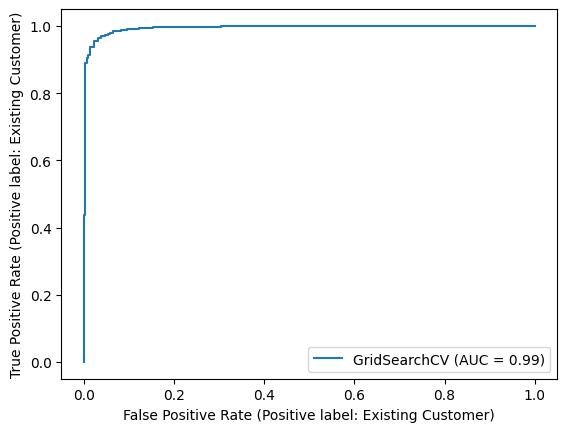

In [41]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

> This is great for the initial cateogrical values that we already have! Now, let's bin together some of our numerical columns in order to run a similar analysis on them and see how the outcome changes. 

### Preparing DataFrames for Testing

In [5]:
df = pd.read_csv('churn_master.csv')
df.shape

(7081, 22)

In [7]:
df_male = df[df.gender == "M"]
df_female = df[df.gender == "F"]

In [6]:
df.columns

Index(['clientnum', 'attrition_flag', 'dependent_count', 'card_category',
       'months_on_book', 'months_inactive_12_mon', 'contacts_count_12_mon',
       'credit_limit', 'avg_open_to_buy', 'avg_utilization_ratio',
       'customer_age', 'gender', 'education_level', 'marital_status',
       'income_category', 'total_relationship_count', 'total_revolving_bal',
       'total_amt_chng_q4_q1', 'total_trans_amt', 'total_ct_chng_q4_q1',
       'total_trans_ct', 'age_group'],
      dtype='object')

In [8]:
# male
data_1 = ['customer_age', 'age_group', 'total_relationship_count', 'income_category']
data_2 = ['avg_open_to_buy', 'avg_utilization_ratio', 'education_level', 'marital_status']
data_3 = ['total_amt_chng_q4_q1', 'total_trans_amt', 'total_ct_chng_q4_q1', 'total_trans_ct']

# female 
data_4 = ['customer_age', 'age_group', 'total_relationship_count', 'income_category']
data_5 = ['avg_open_to_buy', 'avg_utilization_ratio', 'education_level', 'marital_status']
data_6 = ['total_amt_chng_q4_q1', 'total_trans_amt', 'total_ct_chng_q4_q1', 'total_trans_ct']

In [9]:
# male
df1 = df_male[df_male.columns.intersection(data_1)]
df2 = df_male[df_male.columns.intersection(data_2)]
df3 = df_male[df_male.columns.intersection(data_3)]

# female
df4 = df_female[df_female.columns.intersection(data_4)]
df5 = df_female[df_female.columns.intersection(data_5)]
df6 = df_female[df_female.columns.intersection(data_6)]

In [102]:
data_test1 = ['total_trans_amt', 'total_trans_ct']
data_test2 = ['total_amt_chng_q4_q1', 'total_ct_chng_q4_q1']

In [103]:
df_test1 = df[df.columns.intersection(data_test1)]
df_test2 = df[df.columns.intersection(data_test2)]

In [105]:
df_test1['attrition_flag'] = pd.Series(df['attrition_flag'])
df_test2['attrition_flag'] = pd.Series(df['attrition_flag'])

In [114]:
train, test = train_test_split(df_test2, test_size=0.25, random_state=123)
X = train.drop(columns='attrition_flag', axis=1)
y = train['attrition_flag']

### Setting up the pipline for the test DataFrames to go through

In [115]:
## Selecting categorical and numeric features
numerical_ix = X.select_dtypes(include=np.number).columns
categorical_ix = X.select_dtypes(exclude=np.number).columns

## Create preprocessing pipelines for each datatype
numerical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
('encoder', OrdinalEncoder()),
('scaler', StandardScaler())])

## Putting the preprocessing steps together
preprocessor = ColumnTransformer([
('numerical', numerical_transformer, numerical_ix),
('categorical', categorical_transformer, categorical_ix)],
remainder='passthrough')

In [116]:
## Creat list of classifiers we're going to try out
classifiers = [
KNeighborsClassifier(),
SVC(random_state=123),
DecisionTreeClassifier(random_state=123),
RandomForestClassifier(random_state=123),
AdaBoostClassifier(random_state=123),
GradientBoostingClassifier(random_state=123)
]
classifier_names = [
'KNeighborsClassifier()',
'SVC()',
'DecisionTreeClassifier()',
'RandomForestClassifier()',
'AdaBoostClassifier()',
'GradientBoostingClassifier()'
]
model_scores = []
## Looping through the classifiers
for classifier, name in zip(classifiers, classifier_names):
  pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', classifier)])
  score = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean() 
  model_scores.append(score)

In [117]:
# compare the scores

model_performance = pd.DataFrame({
  'Classifier':
    classifier_names,  
  'Cross-validated AUC':
    model_scores
}).sort_values('Cross-validated AUC', ascending = False, ignore_index=True)
display(model_performance)

,Classifier,Cross-validated AUC
0,GradientBoostingClassifier(),0.769871
1,AdaBoostClassifier(),0.766506
2,RandomForestClassifier(),0.723406
3,KNeighborsClassifier(),0.681161
4,SVC(),0.646644
5,DecisionTreeClassifier(),0.594019


In [118]:
# hyperparameter tuning 

#now that we've identified the best candidate we tune the settings to make it best

pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', GradientBoostingClassifier(random_state=123))
])

In [119]:
grid = {
  #"selector__k": ['k-range'],
  "classifier__max_depth":[1,3,5],
  "classifier__learning_rate":[0.01,0.1,1],
  "classifier__n_estimators":[100,200,300,400]
}
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs= 1, scoring='roc_auc')
gridsearch.fit(X, y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)

{'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 400}
0.773702189578714


# df_test2 - Total transaction amount & total transaction count

AUCROC: 0.7972144431735013 
Accuracy: 0.8441558441558441


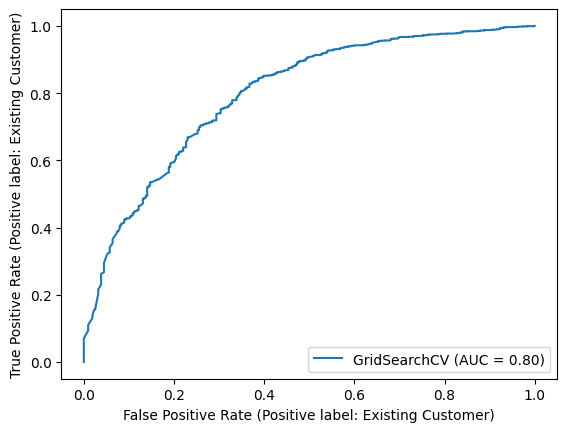

In [120]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

# df_test1 - Total transaction amount & total transaction count

AUCROC: 0.9479581640568505 
Accuracy: 0.9096555618294748


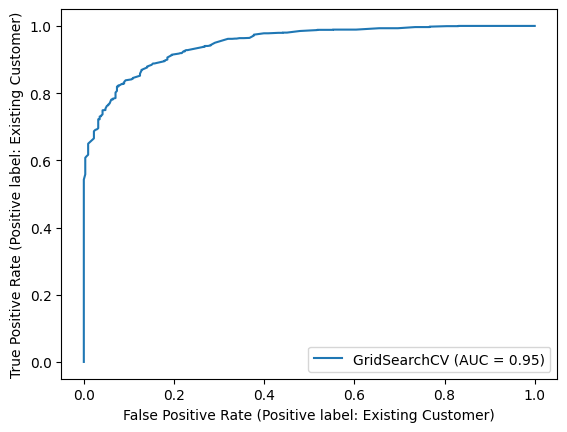

In [113]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

AUCROC: 0.6309775561097256 
Accuracy: 0.8651564185544768


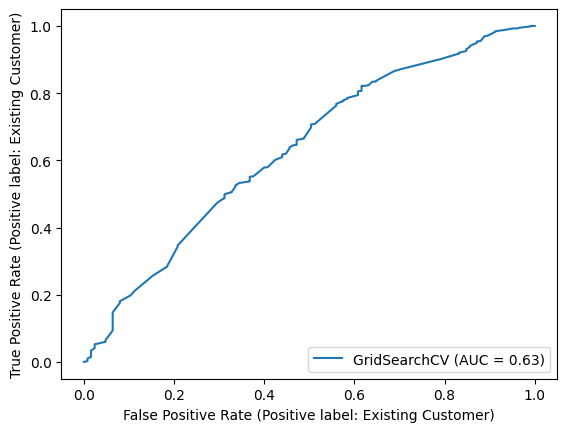

In [19]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

### df2

AUCROC: 0.7647082294264339 
Accuracy: 0.8629989212513485


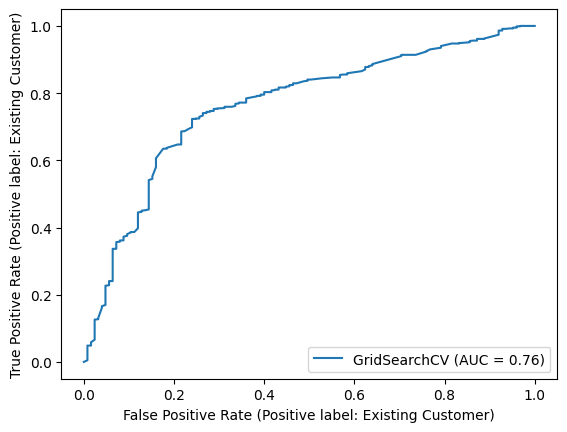

In [28]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

### df3

AUCROC: 0.9622643391521196 
Accuracy: 0.9341963322545846


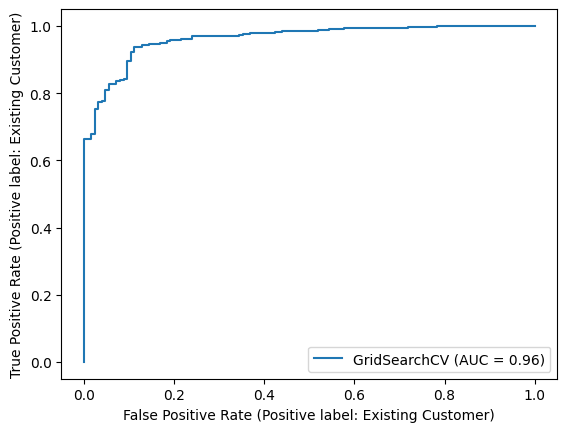

In [58]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

### df4

AUCROC: 0.5998790188751967 
Accuracy: 0.8447867298578199


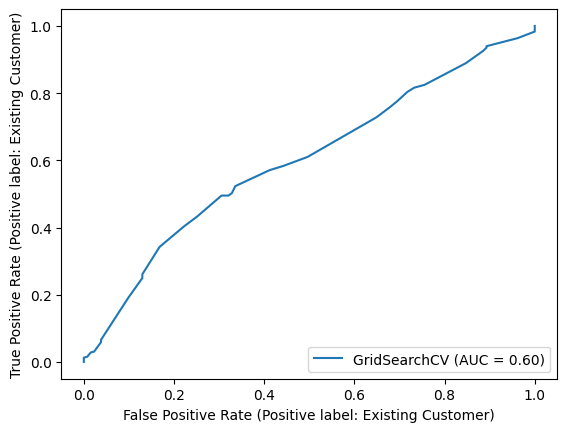

In [65]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

### df5

AUCROC: 0.7555003586608567 
Accuracy: 0.8436018957345972


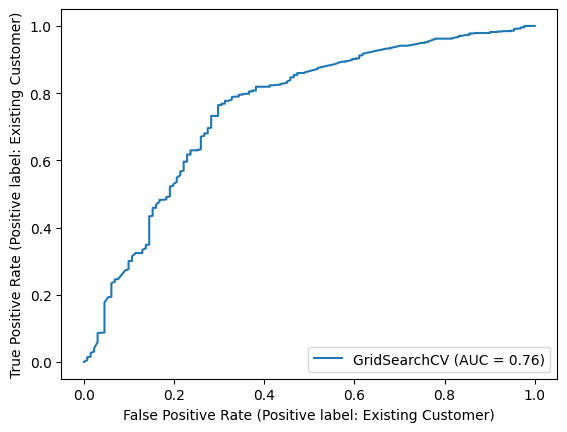

In [72]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

### df6

AUCROC: 0.9821633138121901 
Accuracy: 0.9514218009478673


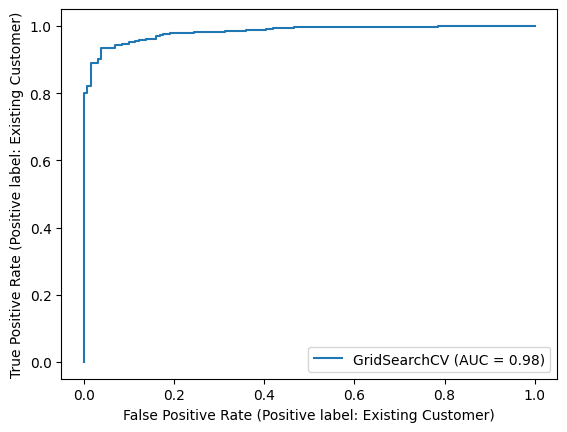

In [79]:
## Separate features and target for the test data
X_test = test.drop(columns='attrition_flag', axis=1)
y_test = test['attrition_flag']

## Refitting the training data with the best parameters
gridsearch.refit

## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Plotting the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

## Checking the results with charts

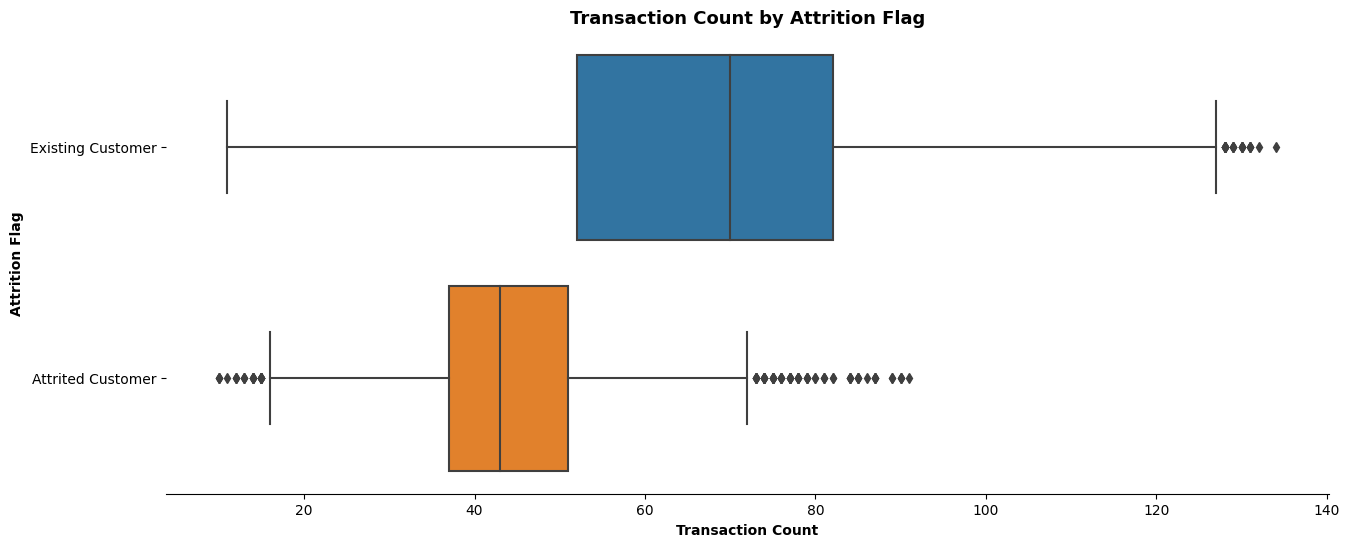

In [121]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.boxplot(x="total_trans_ct",
            y="attrition_flag",
            data=df)

ax.set_title('Transaction Count by Attrition Flag', fontdict={'size': 13, 'weight': 'semibold'})

ax.set_xlabel('Transaction Count', 
               fontweight ='bold')

ax.set_ylabel('Attrition Flag', 
               fontweight = 'bold')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

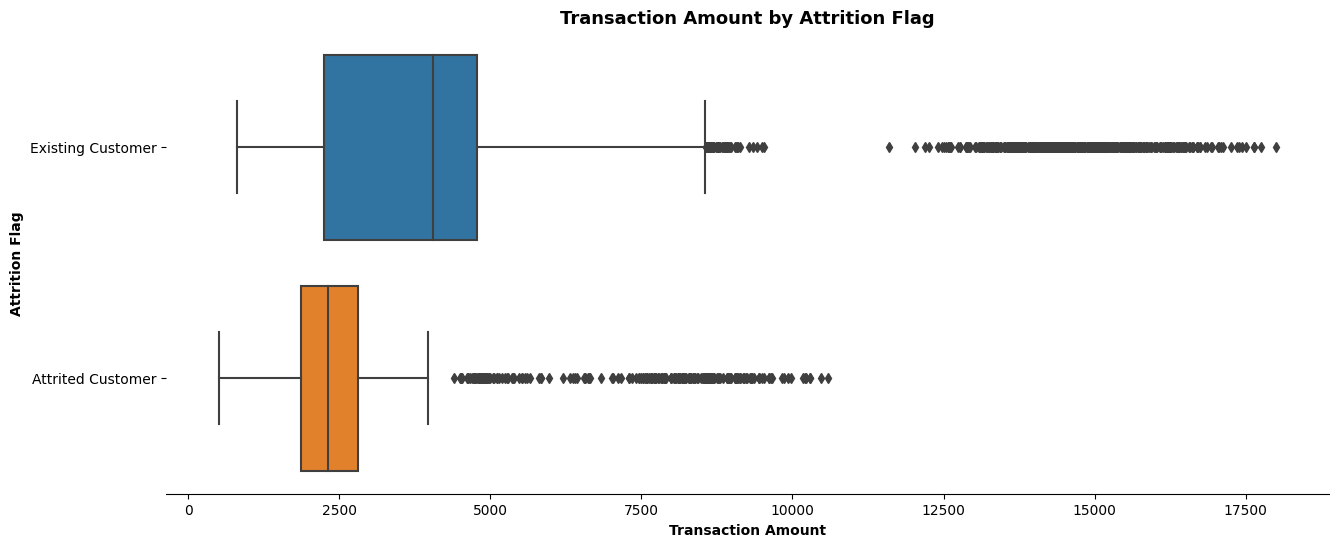

In [123]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.boxplot(x="total_trans_amt",
            y="attrition_flag",
            data=df)

ax.set_title('Transaction Amount by Attrition Flag', fontdict={'size': 13, 'weight': 'semibold'})

ax.set_xlabel('Transaction Amount', 
               fontweight ='bold')

ax.set_ylabel('Attrition Flag', 
               fontweight = 'bold')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

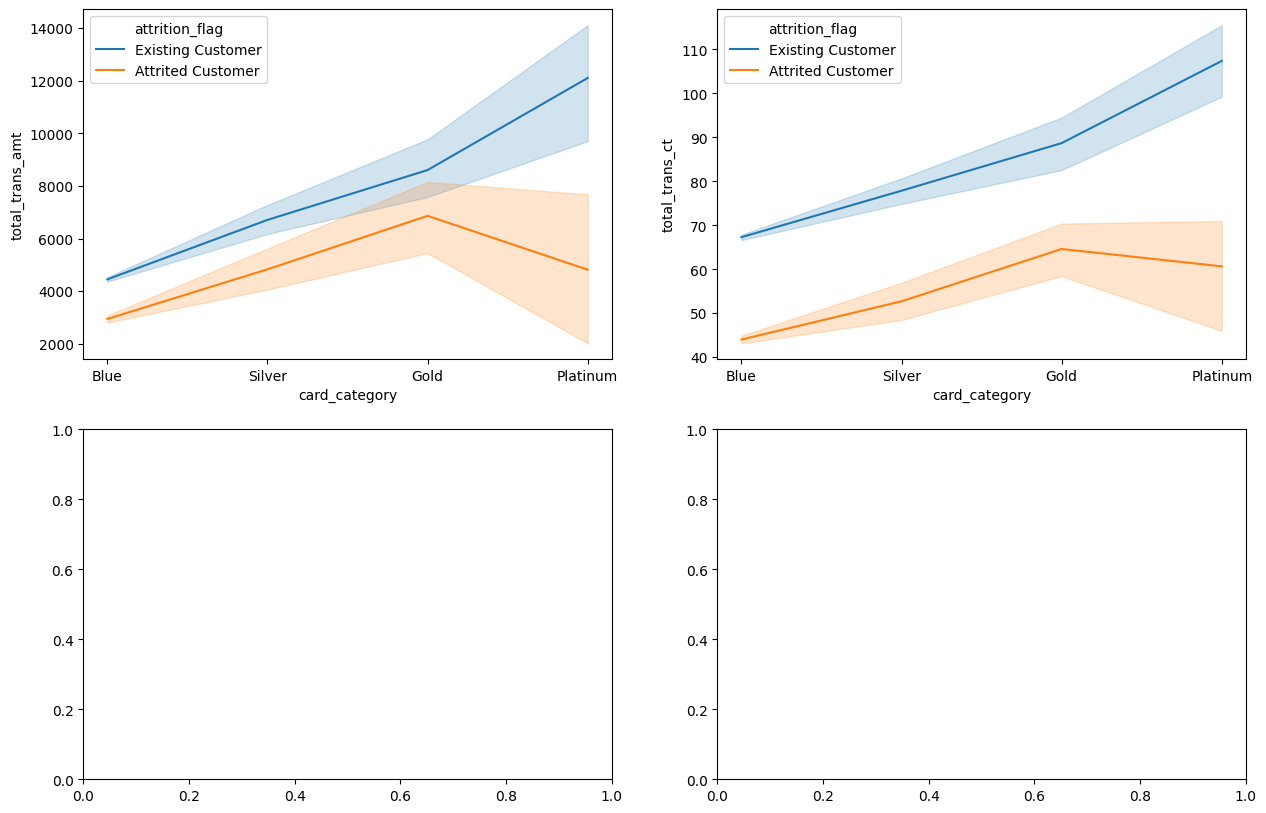

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
    
ax = sns.lineplot(x='card_category', y="total_trans_amt", hue="attrition_flag", data=df, ax=axes[0,0])
ax1 = sns.lineplot(x='card_category', y="total_trans_ct", hue="attrition_flag", data=df, ax=axes[0,1])
